**Build Simple Model**

I will build two simple Logistic Regression models on the filtered data from the previous notebook.  This is so that I can test the impact of either using or ignoring the two demographic columns where we have more missing values.  This notebook will build the second model that excludes demographic detail and then tunes the threshold for assigning positive/negative predictions.

In [1]:
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv("data/filtered_data.csv")
data.drop("Unnamed: 0", axis=1, inplace=True)
data.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,age_dummy,sex_dummy,test_indication_abroad,test_indication_contact,test_indication_other,target
0,1.0,0.0,0.0,0.0,0.0,1,1,0,0,1,0
1,1.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1
2,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0
3,0.0,1.0,0.0,0.0,0.0,0,0,1,0,0,0
4,1.0,0.0,0.0,0.0,0.0,1,0,0,0,1,0


In [3]:
#Split into X and y
X = data.drop("target", axis=1)

#For this workbook also drop demographics
X = X.drop(["age_dummy", "sex_dummy"], axis=1)

y = data.target

In [4]:
#Create a train_test_split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify = y)

In [5]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

print("Score on training data: {}".format(lr.score(X_train, y_train)))
#95% - high accuracy, but it is a biased dataset
pred_train = lr.predict(X_train)

print("Score on testing data: {}".format(lr.score(X_test, y_test)))
#Also 95%
pred_test = lr.predict(X_test)

Score on training data: 0.949172870140612
Score on testing data: 0.9495078645179967


In [6]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

y_train_probs = lr.predict_proba(X_train)
y_train_pred = [1 if x[1] > 0.5 else 0 for x in y_train_probs]

print(f"Precision: {precision_score(y_train, y_train_pred):.3f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.3f}")
print(f"F1 score: {f1_score(y_train, y_train_pred):.3f}")

print(classification_report(y_train, y_train_pred))

Precision: 0.849
Recall: 0.413
F1 score: 0.555
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     89282
           1       0.85      0.41      0.56      7438

    accuracy                           0.95     96720
   macro avg       0.90      0.70      0.76     96720
weighted avg       0.95      0.95      0.94     96720



In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

y_test_probs = lr.predict_proba(X_test)
y_test_pred = [1 if x[1] > 0.5 else 0 for x in y_test_probs]

print(f"Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.3f}")
print(f"F1 score: {f1_score(y_test, y_test_pred):.3f}")

print(classification_report(y_test, y_test_pred))


Precision: 0.862
Recall: 0.409
F1 score: 0.555
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     38264
           1       0.86      0.41      0.55      3188

    accuracy                           0.95     41452
   macro avg       0.91      0.70      0.76     41452
weighted avg       0.95      0.95      0.94     41452



0.8983873649972155


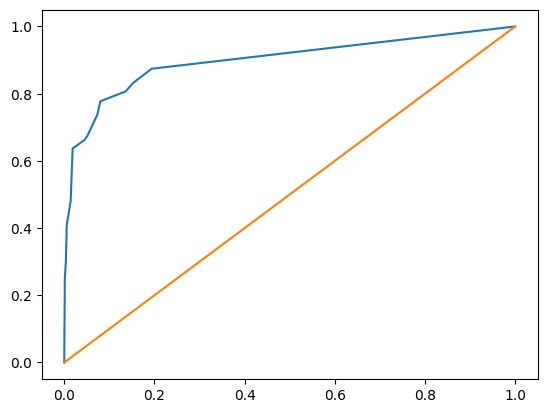

In [8]:
import matplotlib.pyplot as plt

#Use ROC curve to find the right threshold value
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_test_probs[:,1])
print(roc_auc_score(y_test, y_test_probs[:,1]))

fig_roc, ax_roc = plt.subplots()
ROC = roc_curve(y_test, y_test_probs[:,1])
ax_roc.plot(ROC[0], ROC[1])
ax_roc.plot([0, 1], [0, 1])

#We have a ROCAUC score of 0.895 which indicates the model is better than random at guessing, closer to 1 is better
#Try plotting precision versus recall for different thresholds

We can potentially improve our performance by selecting what value we use as the cut-off between true/false predictions

In [9]:
#The 'optimal' value is essentially the point where our blue line (performance) is furthest from the orange line
import math
def performance(fpr, tpr):
    base = max(fpr, tpr)
    dist = (fpr - base)**2 + (tpr - base)**2
    dist = math.sqrt(dist)
    return dist
    
dists = [performance(x, y) for x, y in zip(fpr, tpr)]
dists
best = max(dists)
best

print("Threshold: {}".format(thresholds[dists.index(best)]))
print("FPR: {}".format(fpr[dists.index(best)]))
print("TPR: {}".format(tpr[dists.index(best)]))

threshold = thresholds[dists.index(best)]

#The above gave a threshold that is good for the recall but suffers on precision

Threshold: 0.1120658075385513
FPR: 0.08023207192138825
TPR: 0.777603513174404


In [10]:
y_train_probs = lr.predict_proba(X_train)
y_train_pred = [1 if x[1] > threshold else 0 for x in y_train_probs]

print(f"Precision: {precision_score(y_train, y_train_pred):.3f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.3f}")
print(f"F1 score: {f1_score(y_train, y_train_pred):.3f}")

print(classification_report(y_train, y_train_pred))

Precision: 0.460
Recall: 0.748
F1 score: 0.570
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     89282
           1       0.46      0.75      0.57      7438

    accuracy                           0.91     96720
   macro avg       0.72      0.84      0.76     96720
weighted avg       0.94      0.91      0.92     96720



In [11]:
y_test_probs = lr.predict_proba(X_test)
y_test_pred = [1 if x[1] > threshold else 0 for x in y_test_probs]

print(f"Precision: {precision_score(y_test, y_test_pred):.3f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.3f}")
print(f"F1 score: {f1_score(y_test, y_test_pred):.3f}")

print(classification_report(y_test, y_test_pred))

Precision: 0.456
Recall: 0.737
F1 score: 0.564
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     38264
           1       0.46      0.74      0.56      3188

    accuracy                           0.91     41452
   macro avg       0.72      0.83      0.76     41452
weighted avg       0.94      0.91      0.92     41452

